## Imports

In [18]:
import numpy as np
import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import array
import csv
import time

# import deap packages required
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import pandas as pd

## Load test instance 

In [19]:
# myinst = "./artGalleryTestInstances/pacman.csv"
myinst = ""

instance_file = myinst
instance_size  = 100
num_cells = instance_size * instance_size # total number of cells in the grid

# create a grid that specifies the walls that can be used later to check that no cameras are positioned on walls
walls = np.zeros(instance_size * instance_size)

if myinst != "":
    with open(myinst) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter = ',')
        for line in csv_reader:
            column = int(line[0])
            row = int(line[1])
            oneD_index = (row * instance_size) + column
            walls[oneD_index] = 1

## Executables wrappers

In [20]:
path_binary = "ECO-Coursework-Executables/bit_cam_napier.exe"
path_binary_vis = "ECO-Coursework-Executables/bit_cam_napier_visualisation.exe"

# Do NOT modify this code - this calls an external binary with a solution
def objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary,str(instance_size),str(nb_cameras)]+params+[instance_file]
    s = subprocess.check_output(cmd)
    return float(s)


# Do NOT modify: this checks whether a camera is positioned on top of wall in a solution
def check_walls(solution, inst):
    clashes=0
    for i in range(0, len(solution)):
        if (walls[i] == 1 and solution[i]==1):
            clashes+=1
            
    return(clashes)

## Individual initialisation

In [21]:
max_cameras = 300
compressed_grid_size = 50
compressed_cells = compressed_grid_size * compressed_grid_size
full_grid_size = 100
full_grid_cells = full_grid_size * full_grid_size

def generate_individual():
    nb_cam = random.randint(1, max_cameras)
    individual = np.zeros(compressed_cells)
    # select which positions should have cameras
    indexes = random.sample(range(0, compressed_cells), nb_cam)
    for j in indexes:
        individual[j] = 1

    full_solution = convert_compressed_to_full(individual)

    if len(cameras_on_walls(full_solution)) > 0:
        repair_solution(full_solution)
        individual = convert_full_to_compressed(full_solution)

    return individual

def convert_compressed_to_full(individual):
    solution = [0] * full_grid_cells

    for i in range(len(individual)):
        if individual[i] == 1:
            # Determine the row and column in the compressed grid
            row_compressed = i // compressed_grid_size
            col_compressed = i % compressed_grid_size
            
            # Calculate the top-left index of the corresponding 2x2 block in the full grid
            top_left_index = (row_compressed * 2 * full_grid_size) + (col_compressed * 2)
            
            # Set the top-left cell in the 2x2 block
            solution[top_left_index] = 1

    return solution

def convert_full_to_compressed(solution):
    individual = []
    
    # Iterate through 2x2 blocks
    for i in range(0, full_grid_size, 2):  # Rows
        for j in range(0, full_grid_size, 2):  # Columns
            # Calculate indices of the 2x2 block
            top_left = i * full_grid_size + j
            top_right = top_left + 1
            bottom_left = top_left + full_grid_size
            bottom_right = bottom_left + 1
            
            # Determine the compressed value for this block
            if (
                solution[top_left] == 1 or
                solution[top_right] == 1 or
                solution[bottom_left] == 1 or
                solution[bottom_right] == 1
            ):
                individual.append(1)
            else:
                individual.append(0)
    
    return individual


## Repair function

In [22]:
def cameras_on_walls(solution):
    positions = []
    for i in range(0, len(solution)):
        if (walls[i] == 1 and solution[i] == 1):
            positions.append(i)
            
    return(positions)

# delete all cameras that are on the walls 
def repair_solution(solution):
    clash_positions = cameras_on_walls(solution)

    for pos in clash_positions:
        solution[pos] = 0

def add_single_camera(individual):
    position = random.randint(0, compressed_cells)
    individual[position] = 1

## Custom mutation

In [23]:
def get_cell_neighbours(individual, cell):
    neighbours = []
    row = cell // 50
    col = cell % 50

    for row_change in [-1, 0, 1]:
        for col_change in [-1, 0, 1]:
            neighbour_row = row + row_change
            neighbour_col = col + col_change

            if 0 <= neighbour_row < 50 and 0 <= neighbour_col < 50:
                neighbour_index = neighbour_row * 50 + neighbour_col
                if individual[neighbour_index] == 1:
                    neighbours.append(neighbour_index)

    return neighbours

def remove_neighbouring_cameras(individual, neighbours: list):
    if neighbours:
        to_keep = random.choice(neighbours)
        neighbours.remove(to_keep)
        for cell in neighbours:
            if random.random() < 0.7:
                individual[cell] = 0


def neighbourhood_mutation(individual):
    for cell in range(len(individual)):
        if individual[cell] == 1:
            neighbours = get_cell_neighbours(individual, cell)
            remove_neighbouring_cameras(individual, neighbours)

    return individual,

## Evaluation function

In [24]:
def eval_function(individual):
    solution = []
    total_cameras = 99999
    fitness = total_cameras

    # convert individual to the solution list - this depends on the representation
    solution = convert_compressed_to_full(individual)

    # make sure there's at least one camera
    if sum(solution) < 1:
        add_single_camera(individual)
    
    # check if cameras on walls
    if instance_file == "":
        cameras_on_walls = 0
    else:
        cameras_on_walls = check_walls(solution, instance_file) 

    if cameras_on_walls > 0:
        repair_solution(solution)
        individual = convert_full_to_compressed(solution)

    total_cameras = np.sum(solution)

    # only call this if the solution is not invalid
    coverage = objective_function(solution, instance_size, total_cameras, instance_file)

    if coverage < 0.99: 
        uncovered = (1 - coverage) * 100
        penalty = uncovered * uncovered * 2
        fitness = total_cameras + penalty  
    else:
        fitness = total_cameras 

    return fitness,

## Hill climber

In [25]:
def get_all_camera_positions(solution):
    return [i for i, value in enumerate(solution) if value == 1]

def generate_valid_neighbours(solution, eval_counter):
    valid_neighbours = []
    all_cameras = get_all_camera_positions(solution)
    for cam in all_cameras:
        neighbour = solution.copy()
        neighbour[cam] = 0
        converted = convert_compressed_to_full(neighbour)
        cams = np.sum(neighbour)
        coverage = objective_function(converted, instance_size, cams, instance_file)
        eval_counter += 1
        if coverage > 0.99:
            valid_neighbours.append((cam, coverage))

    return valid_neighbours, eval_counter


def pick_a_neighbour(neighbours):
    sorted_neighbours = sorted(neighbours, key=lambda x: x[1], reverse=True)
    best_neighbour = sorted_neighbours[0]
    highest_items = [item for item in sorted_neighbours if item[1] == best_neighbour[1]]
    
    return random.choice(highest_items)


def hill_climber(solution):
    eval_counter = 0
    best_solution = solution
    min_num_cameras = np.sum(solution)
    initial_min_cameras = min_num_cameras

    # set the maximum number of tries
    max_tries = 50
    
    # now run the HC loop : 
    for i in range(max_tries-1):
        valid_neighbours, eval_counter = generate_valid_neighbours(best_solution, eval_counter)
        if len(valid_neighbours) <= 0:
            break
        
        chosen_neighbour = pick_a_neighbour(valid_neighbours)
        
        new_solution = best_solution.copy()
        new_solution[chosen_neighbour[0]] = 0
        new_coverage = chosen_neighbour[1]
        new_cameras = np.sum(new_solution)
        
        if new_coverage > 0.99:
            min_num_cameras = new_cameras
            best_solution = new_solution.copy()

    print("Starting camera number %s Best found %s improvement of %s" % (initial_min_cameras, min_num_cameras, initial_min_cameras-min_num_cameras))  
   
    # return the results
    return best_solution, eval_counter

## Setup the EA

In [26]:
# SETUP THE EA
# define the fitness class and creare an individual class
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


# create a toolbox
toolbox = base.Toolbox()

toolbox.register("individual", lambda: creator.Individual(generate_individual()))

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# register all operators we need with the toolbox
toolbox.register("evaluate", eval_function)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", neighbourhood_mutation)
toolbox.register("select", tools.selTournament, tournsize=2)

c:\Users\julka\anaconda3\envs\eco\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\julka\anaconda3\envs\eco\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


## Main EA definition

In [27]:
population = 50
generations = 50
def main():
    
    # choose a population size: e.g. 200
    pop = toolbox.population(n=population)
    
    # keep track of the single best solution found
    hof = tools.HallOfFame(1)
 
    # create a statistics object: we can log what ever statistics we want using this. We use the numpy Python library
    # to calculate the stats and label them with convenient labels
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    # run the algorithm: we need to tell it what parameters to use
    # cxpb = crossover probability; mutpb = mutation probability; ngen = number of iterations
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.6, mutpb=0.05, ngen=generations, stats=stats, halloffame=hof, verbose=True)
    
    return pop, log, hof

## Helpers

In [28]:
def run_ea():
    start = time.time()
    pop, log, hof = main()
    stop = time.time()
    run_time = stop - start

    best_fit = hof[0].fitness.values[0]   # best fitness found is stored at index 0 in the hof list

    # look in the logbook to see what generation this was found at
    min = log.select("min")  # max fitness per generation stored in log

    for gen in range(generations):  # set to ngen
            fit = min[gen]
            if fit == best_fit:
                break     
    
    print("min fitness found is %s at generation %s" % (best_fit, gen))

    nevals = log.select("nevals")
    total_ea_nevals = np.sum(nevals)

    return hof[0], best_fit, gen, total_ea_nevals, run_time

def run_hc(ea_solution):
    start = time.time()
    best_hc, eval_counter = hill_climber(ea_solution)
    stop = time.time()
    timeHC = stop - start

    hc_best_cameras = np.sum(best_hc)

    return best_hc, hc_best_cameras, eval_counter, timeHC

# Run this cell to define the functions
def solution_converter(index, instance_size):
    counter = 0
    for i in range(instance_size):
        for j in range(instance_size):
            if (counter == index):
                return i,j
            else:
                counter+=1

def get_coordinates(solution):
    full_solution = convert_compressed_to_full(solution)
    cameras_indices = [index for (index, item) in enumerate(full_solution) if item == 1]
    coordinates = []
    for c in cameras_indices:
        x,y = solution_converter(c, instance_size=instance_size)
        coordinates.append((y,x))

    return coordinates


## Run the EA

In [29]:
for run in range(0, 1):
    ea_solution, ea_min_cams, ea_best_gen, ea_nevals, ea_time = run_ea()
    
    hc_solution, hc_min_cams, hc_evals, hc_time = run_hc(ea_solution)
    
    total_nevals = ea_nevals + hc_evals

    camera_coordinates = get_coordinates(hc_solution)

    with open("output.csv", mode = "a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([ea_min_cams, hc_min_cams, ea_best_gen, ea_time, hc_time, total_nevals, camera_coordinates])

gen	nevals	avg    	std    	min    	max
0  	50    	162.887	66.3126	30.3282	299
1  	26    	132.04 	53.0539	33     	231
2  	32    	100.28 	34.9623	32     	185
3  	29    	79.86  	21.6896	33     	126
4  	31    	66.3   	16.7192	33     	106
5  	28    	54.54  	11.4337	33     	85 
6  	35    	50.3072	9.43645	32     	72.3618
7  	30    	44.52  	7.36272	31     	61     
8  	30    	41.1976	6.14762	31     	53     
9  	35    	37.5176	5.11214	31     	52     
10 	23    	33.48  	3.23258	30     	43     
11 	35    	31.6186	1.41027	28     	37     
12 	30    	31.0111	1.22255	28     	35.5538
13 	28    	30.38  	1.18136	27     	34     
14 	33    	29.7   	1.38924	27     	33     
15 	40    	29.0329	1.15959	27     	32.645 
16 	32    	28.28  	0.800999	27     	30     
17 	35    	27.94  	0.704557	27     	30     
18 	20    	27.62  	0.628967	27     	30     
19 	32    	27.42  	0.493559	27     	28     
20 	32    	27.18  	0.384187	27     	28     
21 	39    	27.02  	0.14    	27     	28     
22 	29    	27     	0       	27   

## Visualise solution and statistics

27
0.9901
0
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

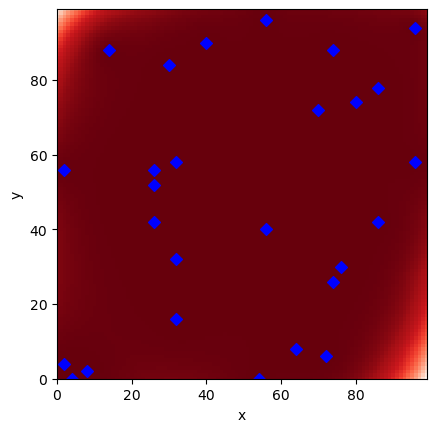

17
0.9901
0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

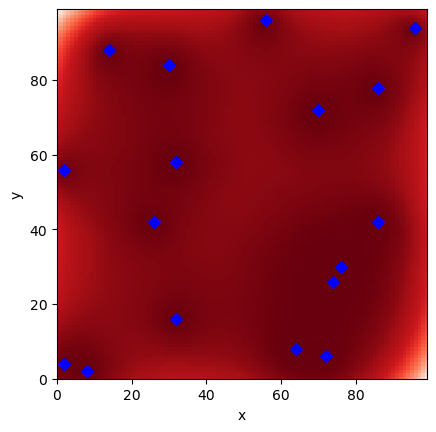

In [30]:
# assumes path_binary is already set 
def visualise_objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary_vis,str(instance_size),str(nb_cameras)]+params+[instance_file]
    with open("temp_results.csv",'w') as fd:
        s = subprocess.call(cmd, stdout=fd)
    # Plotting the probability of detection
    data = pd.read_csv("temp_results.csv")
    values = np.array(data["value"])
    values[values < 0.5] = 0
    values = values.reshape(instance_size,instance_size)
    plt.imshow(values,cmap="Reds")
    # Plotting cameras
    cameras_indices = [index for (index, item) in enumerate(list(x)) if item == 1]
    for c in cameras_indices:
        x,y = solution_converter(c, instance_size=instance_size)
        plt.scatter(y,x,c="blue",marker="D")
    # Plotting walls (if any)
    if (instance_file != ""):
        walls = pd.read_csv(instance_file,header=None)
        plt.scatter(walls[1],walls[0],c="black", marker="_")
    plt.xlim(0,instance_size-1)
    plt.xlabel("x")
    plt.ylim(0,instance_size-1)
    plt.ylabel("y")
    plt.show()
    
# Here we just create a random solution for a 100x100 grid with two cameras at random positions
# you can experiment to see what different solutions look like
sols = []
sols.append(ea_solution)
sols.append(hc_solution)

for sol in sols:
    final_solution = sol
    final_solution = convert_compressed_to_full(final_solution)

    actual_cameras=sum(final_solution)  # need to pass the actual numbers of cameras in the solution, regardless of whether it is valid
    print(actual_cameras)
    coverage = objective_function(final_solution, instance_size, actual_cameras, instance_file)
    print(coverage)
    cameras_on_walls = check_walls(final_solution, instance_file) 
    print(cameras_on_walls)
    print(final_solution)

    visualise_objective_function(final_solution, instance_size=instance_size, nb_cameras=actual_cameras, instance_file=myinst)


In [31]:
# code for plotting

# gen = log.select("gen")
# fit_max = log.select("max")
# fit_min = log.select("min")
# fit_avg = log.select("avg")

# fig, ax1 = plt.subplots()
# line1 = ax1.plot(gen, fit_max, "b-", label="max Fitness", color="r")
# line2 = ax1.plot(gen, fit_min, "b-", label="min Fitness", color="b")
# line3 = ax1.plot(gen , fit_avg, "b-", label="avg Fitness", color="g")
# ax1.set_xlabel("Generations")
# ax1.set_ylabel("Fitness", color="b")
# for tl in ax1.get_yticklabels():
#     tl.set_color("b")
# ax1.set_ylim(0,1000)
    
# lns = line1+line2+line3
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, loc="center right")
